In [96]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt # Visualization
import seaborn as sns # Visualization

from itertools import combinations

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import STL

In [97]:
data = pd.read_csv('weather_prediction_dataset.csv')
labels = pd.read_csv('weather_prediction_bbq_labels.csv')

In [98]:
display(data.head(5))

,DATE,MONTH,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,...,STOCKHOLM_temp_min,STOCKHOLM_temp_max,TOURS_wind_speed,TOURS_humidity,TOURS_pressure,TOURS_global_radiation,TOURS_precipitation,TOURS_temp_mean,TOURS_temp_min,TOURS_temp_max
0,20000101,1,8,0.89,1.0286,0.20,0.03,0.0,2.9,1.6,...,-9.3,0.7,1.6,0.97,1.0275,0.25,0.04,8.5,7.2,9.8
1,20000102,1,8,0.87,1.0318,0.25,0.00,0.0,3.6,2.7,...,0.5,2.0,2.0,0.99,1.0293,0.17,0.16,7.9,6.6,9.2
2,20000103,1,5,0.81,1.0314,0.50,0.00,3.7,2.2,0.1,...,-1.0,2.8,3.4,0.91,1.0267,0.27,0.00,8.1,6.6,9.6
3,20000104,1,7,0.79,1.0262,0.63,0.35,6.9,3.9,0.5,...,2.5,4.6,4.9,0.95,1.0222,0.11,0.44,8.6,6.4,10.8
4,20000105,1,5,0.90,1.0246,0.51,0.07,3.7,6.0,3.8,...,-1.8,2.9,3.6,0.95,1.0209,0.39,0.04,8.0,6.4,9.5


In [99]:
display(labels.head(5))

,DATE,BASEL_BBQ_weather,BUDAPEST_BBQ_weather,DE_BBQ_weather,DRESDEN_BBQ_weather,DUSSELDORF_BBQ_weather,HEATHROW_BBQ_weather,KASSEL_BBQ_weather,LJUBLJANA_BBQ_weather,MAASTRICHT_BBQ_weather,MALMO_BBQ_weather,MONTELIMAR_BBQ_weather,MUENCHEN_BBQ_weather,OSLO_BBQ_weather,PERPIGNAN_BBQ_weather,SONNBLICK_BBQ_weather,STOCKHOLM_BBQ_weather,TOURS_BBQ_weather
0,20000101,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,20000102,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,20000103,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,20000104,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,20000105,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [100]:
num_rows, num_columns = data.shape
print(f'Number of rows: {num_rows}')
print(f'Number of columns: {num_columns}')

Number of rows: 3654
Number of columns: 165


In [101]:
def assign_season(month):
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Autumn'
    else:
        return 'Winter'

In [102]:
data['Season'] = data['MONTH'].apply(assign_season)

In [103]:
# Identify unique measurements across stations and get city names
measurements = set()
city_names = set()

for col in data.columns:
    if '_' in col:
        parts = col.split('_')
        measurement_index = 0
        for word in parts:
            if word[0].isupper():
                measurement_index += 1
        measurements.add('_'.join(col.split('_')[measurement_index:]))
        city_names.add('_'.join(col.split('_')[:measurement_index]))
        
print(measurements)
print(city_names)

{'sunshine', 'pressure', 'humidity', 'precipitation', 'temp_min', 'wind_speed', 'wind_gust', 'global_radiation', 'temp_max', 'temp_mean', 'cloud_cover'}
{'OSLO', 'BUDAPEST', 'MUENCHEN', 'ROMA', 'SONNBLICK', 'DUSSELDORF', 'BASEL', 'DE_BILT', 'KASSEL', 'MALMO', 'PERPIGNAN', 'MONTELIMAR', 'MAASTRICHT', 'STOCKHOLM', 'LJUBLJANA', 'TOURS', 'HEATHROW', 'DRESDEN'}


In [104]:
# Define the operations to perform for each measurement
operations = ['mean', 'median', 'std']

# Automate aggregation
results = {}
for measure in measurements:
    columns_to_aggregate = [col for col in data.columns if measure in col]
    aggregated_data = data[columns_to_aggregate].agg(operations)
    results[measure] = aggregated_data

results_df = pd.concat(results, axis=1)

In [105]:
display(results_df)

sunshine                                                      \
       BASEL_sunshine BUDAPEST_sunshine DE_BILT_sunshine DRESDEN_sunshine   
mean         4.661193          5.753229         4.744444         4.815736   
median       3.600000          5.900000         4.100000         3.900000   
std          4.330112          4.475439         3.995637         4.426682   

                                                              \
       DUSSELDORF_sunshine HEATHROW_sunshine KASSEL_sunshine   
mean              4.324111          4.433498        4.136836   
median            3.200000          3.700000        2.900000   
std               4.209463          3.982646        4.159699   

                                                                 ...  \
       LJUBLJANA_sunshine MAASTRICHT_sunshine MUENCHEN_sunshine  ...   
mean             5.412397            4.652354          5.219814  ...   
median           5.200000            3.950000          4.400000  ...   
std              4.507394            4.015278          4.594811  ...   

               cloud_cover                                              \
       DRESDEN_cloud_cover DUSSELDORF_cloud_cover HEATHROW_cloud_cover   
mean              5.405036               5.141762             5.272031   
median            6.000000               6.000000             6.000000   
std               2.194769               2.115639             2.011846   

                                                                          \
       LJUBLJANA_cloud_cover MAASTRICHT_cloud_cover MUENCHEN_cloud_cover   
mean                4.930213               5.337712             5.226054   
median              5.000000               6.000000             6.000000   
std                 2.367843               2.401823             2.318547   

                                                                \
       OSLO_cloud_cover ROMA_cloud_cover SONNBLICK_cloud_cover   
mean           5.608101         3.520799              5.446907   
median         6.000000         3.000000              6.000000   
std            2.170706         2.198344              2.437457   

                              
       STOCKHOLM_cloud_cover  
mean                5.245758  
median              6.000000  
std                 3.362460  

[3 rows x 163 columns]

In [106]:
display(results_df['precipitation'])

,BASEL_precipitation,BUDAPEST_precipitation,DE_BILT_precipitation,DRESDEN_precipitation,DUSSELDORF_precipitation,HEATHROW_precipitation,KASSEL_precipitation,LJUBLJANA_precipitation,MAASTRICHT_precipitation,MALMO_precipitation,MONTELIMAR_precipitation,MUENCHEN_precipitation,OSLO_precipitation,PERPIGNAN_precipitation,SONNBLICK_precipitation,STOCKHOLM_precipitation,TOURS_precipitation
mean,0.234849,0.136442,0.236888,0.175881,0.218043,0.178279,0.202211,0.367263,0.220649,0.166732,0.253426,0.261700,0.239792,0.150733,0.541475,0.149039,0.186100
median,0.000000,0.000000,0.010000,0.000000,0.010000,0.020000,0.010000,0.000000,0.010000,0.000000,0.000000,0.010000,0.000000,0.000000,0.180000,0.000000,0.000000
std,0.536267,0.408932,0.459495,0.459725,0.439578,0.367572,0.407147,0.916321,0.444137,0.395186,0.910761,0.599618,0.512402,0.772949,0.771348,0.345369,0.422151


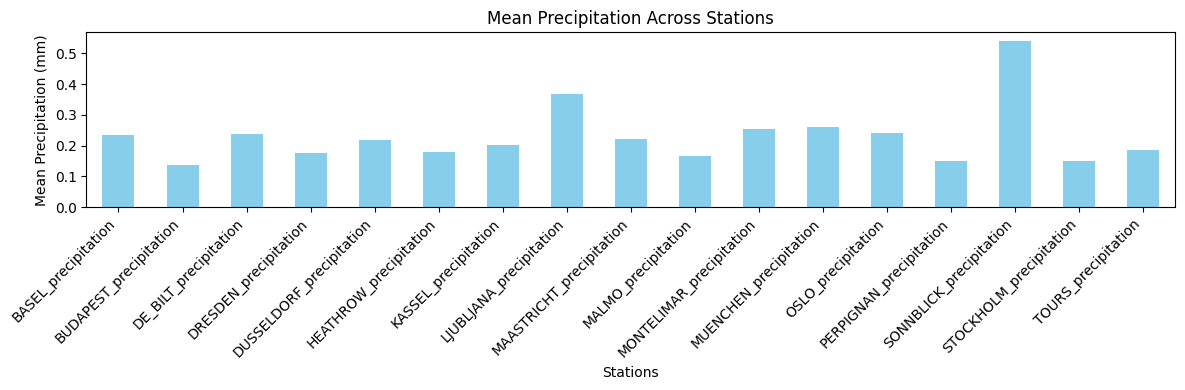

In [107]:
# Plotting the data
plt.figure(figsize=(12, 4))  # Adjust figure size to ensure labels fit well
ax = results_df['precipitation'].iloc[0].plot(kind='bar', color='skyblue')
ax.set_title('Mean Precipitation Across Stations')
ax.set_ylabel('Mean Precipitation (mm)')
ax.set_xlabel('Stations')

# Rotate labels to prevent overlap
plt.xticks(rotation=45, ha='right')  # Rotate labels slightly and align right for better fit

# Adjust font size
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout() # Enhance readability
plt.show()

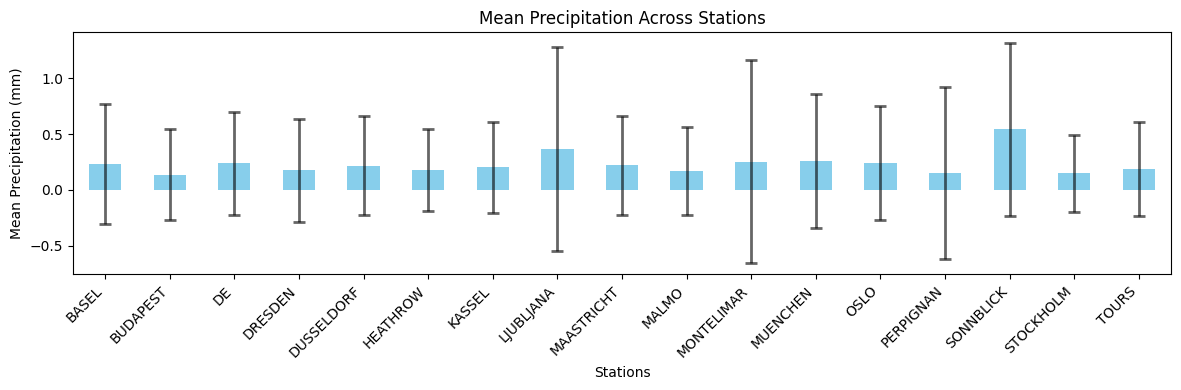

In [108]:
stations = [col.split('_')[0] for col in results_df['precipitation'].columns if '_' in col]

means = results_df['precipitation'].iloc[0].values
medians = results_df['precipitation'].iloc[1].values
st_devs = results_df['precipitation'].iloc[2].values

# Plotting the data
plt.figure(figsize=(12, 4))  # Adjust figure size to ensure labels fit well
ax = results_df['precipitation'].iloc[0].plot(
    kind='bar', color='skyblue', yerr=st_devs, capsize=4,  # capsize adds horizontal lines at the error bar tops
    error_kw={'capthick': 2, 'elinewidth': 2, 'alpha': 0.6}  # Customize error bars for better visibility
)
ax.set_title('Mean Precipitation Across Stations')
ax.set_ylabel('Mean Precipitation (mm)')
ax.set_xlabel('Stations')

# Rotate labels to prevent overlap
ax.set_xticklabels(stations, rotation=45, ha='right') # Rotate labels slightly and align right for better fit

# Adjust font size
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()  # Enhance readability
plt.show()


In [109]:
def get_monthly_precipitation(REGION):
    label = REGION

    fig, axes = plt.subplots(3, 4, figsize=(15,10)) # Grid of plots for 12 months
    axes = axes.flatten() # Flatter 2D array of axes to simplify indexing

    # Colors for the histograms
    colors = ['blue', 'red', 'green', 'orange', 'black', 'cyan', 'yellow', 'magenta', 'pink', 'olive', 'grey', 'purple']
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'Novemeber', 'December']

    for i in range(1, 13):
        ax = axes[i-1] # Choose the appropriate subplot
        month_data = data[data['MONTH'] == i][label]
        ax.hist(month_data, color=colors[i-1], label=f'Month{i}', alpha=0.7, density=True)
        ax.set_title(f"{label.split('_')[0]} for {months[i-1]}")
        ax.set_xlabel('Precipitation')
        ax.legend()

    fig.tight_layout()
    plt.show()

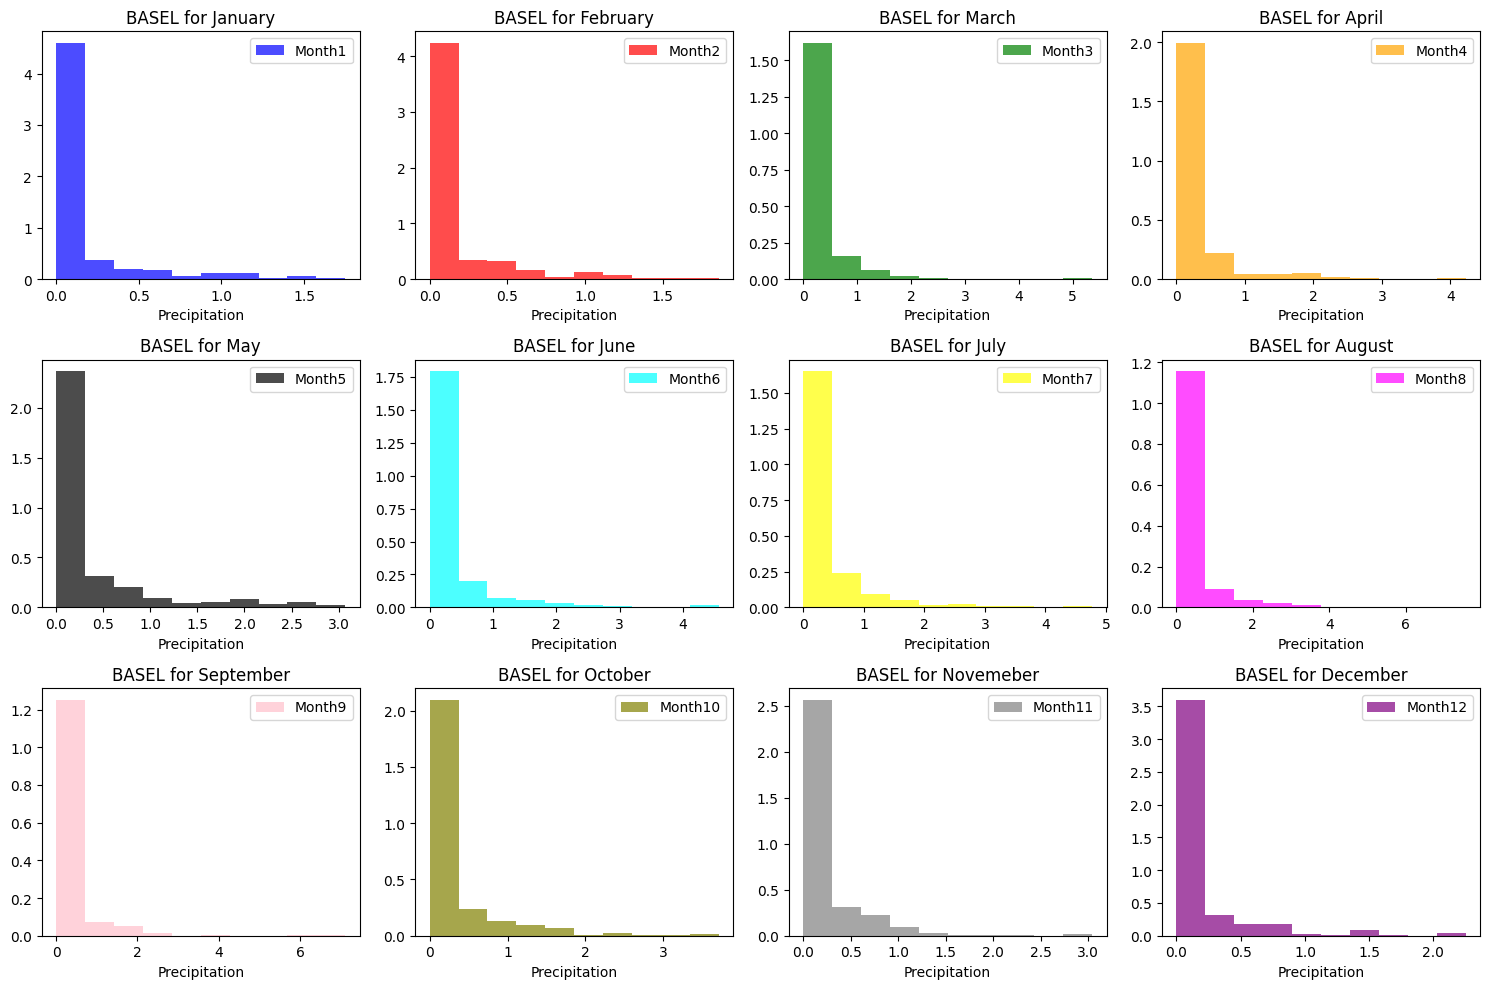

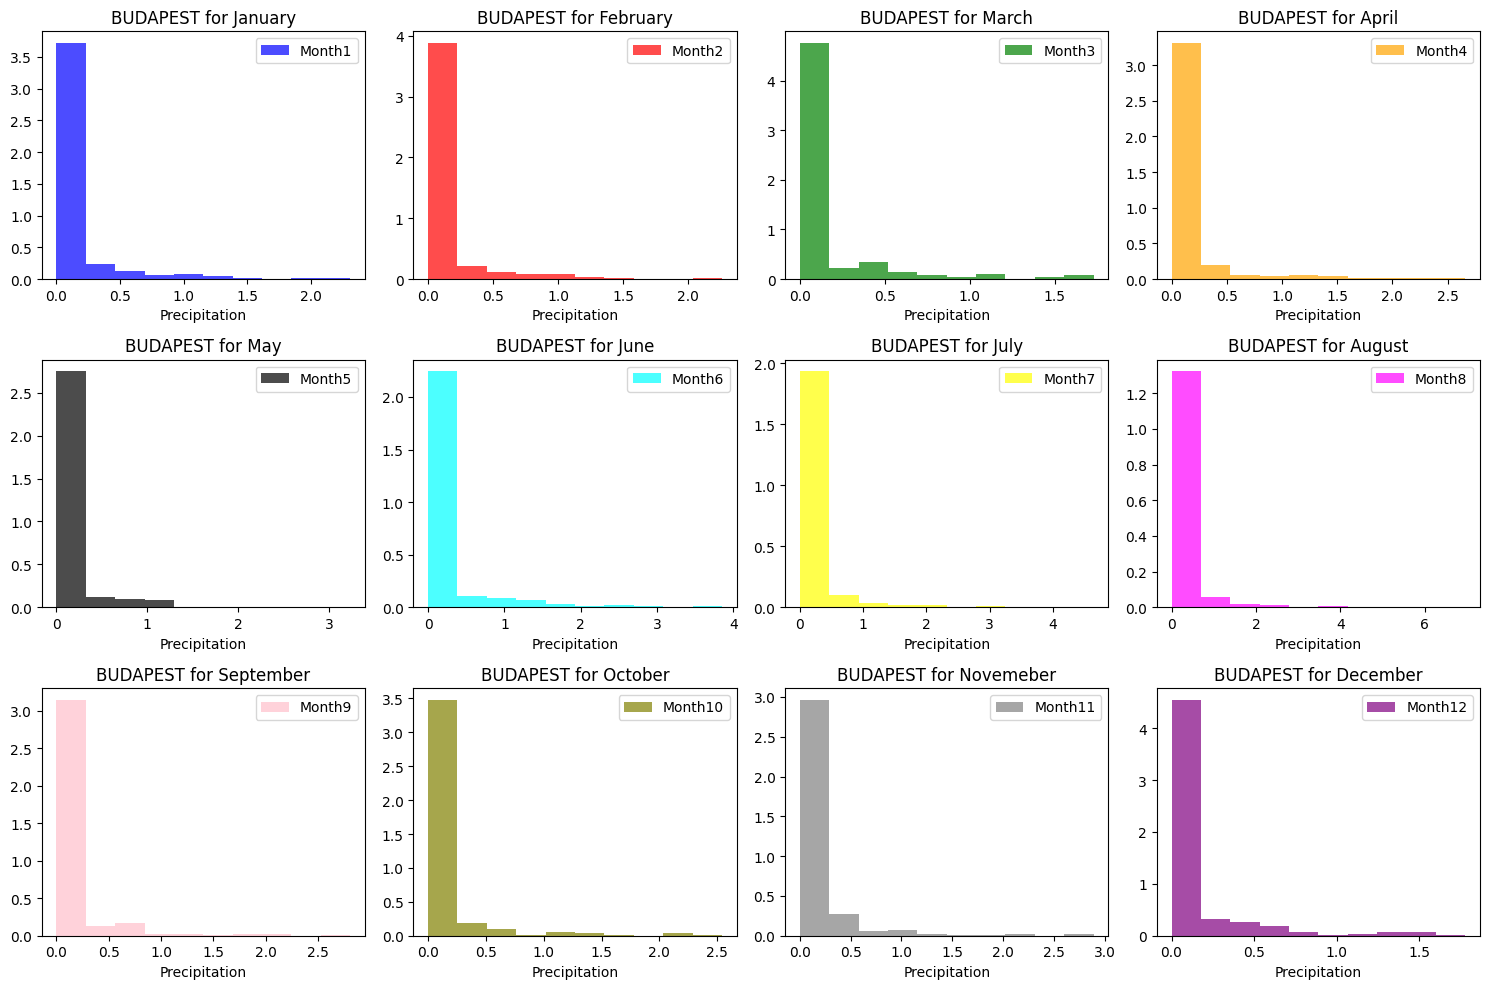

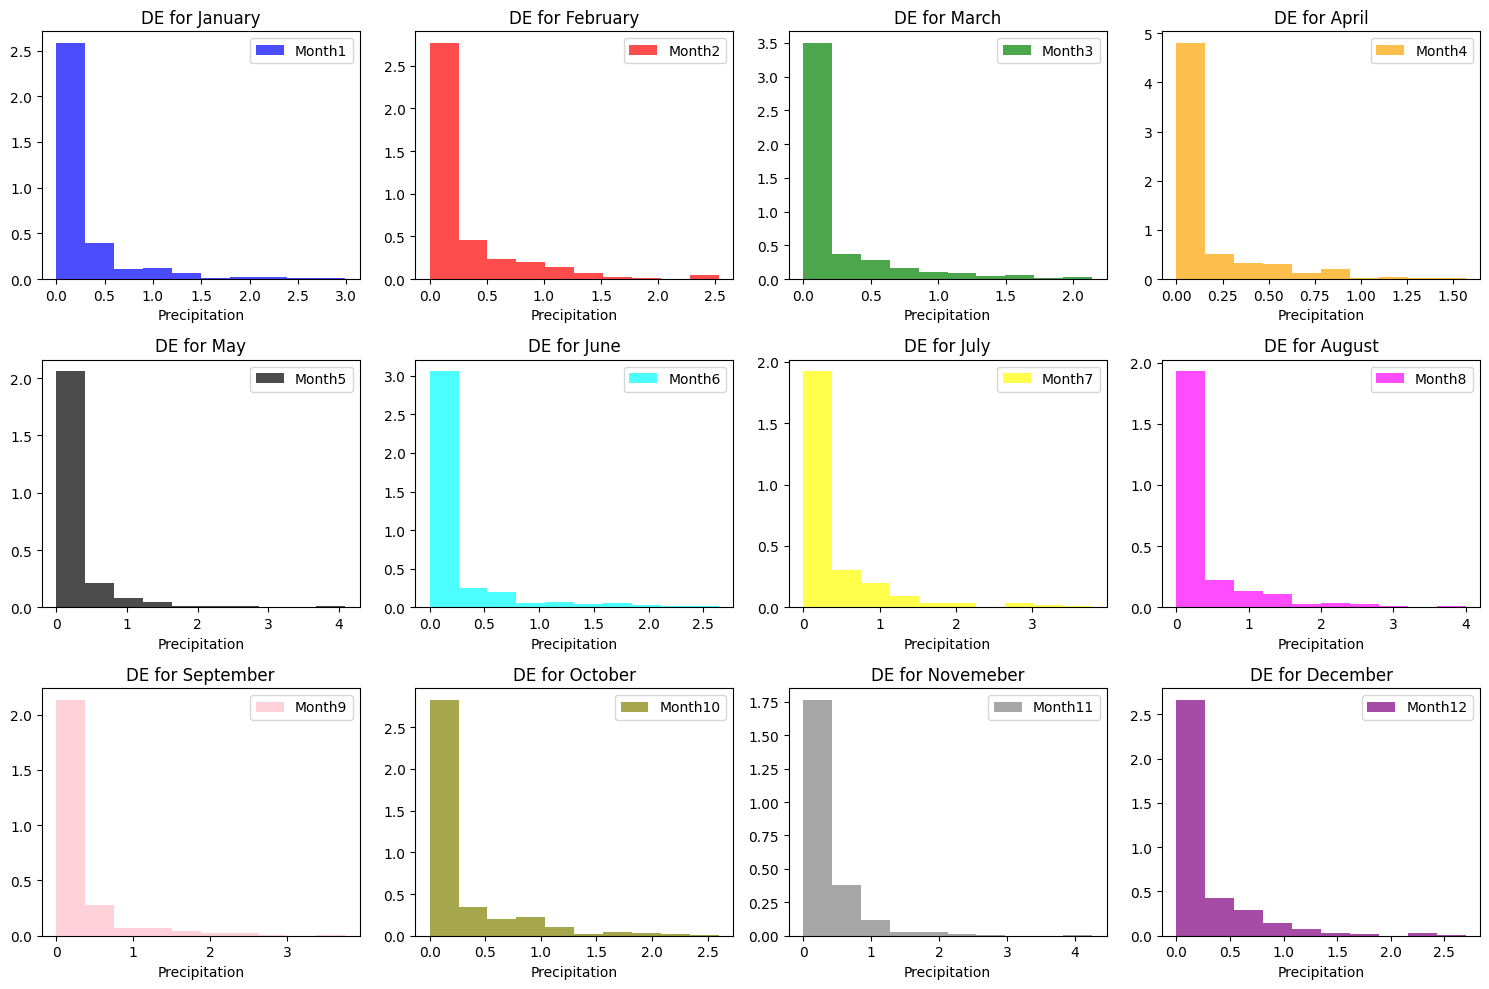

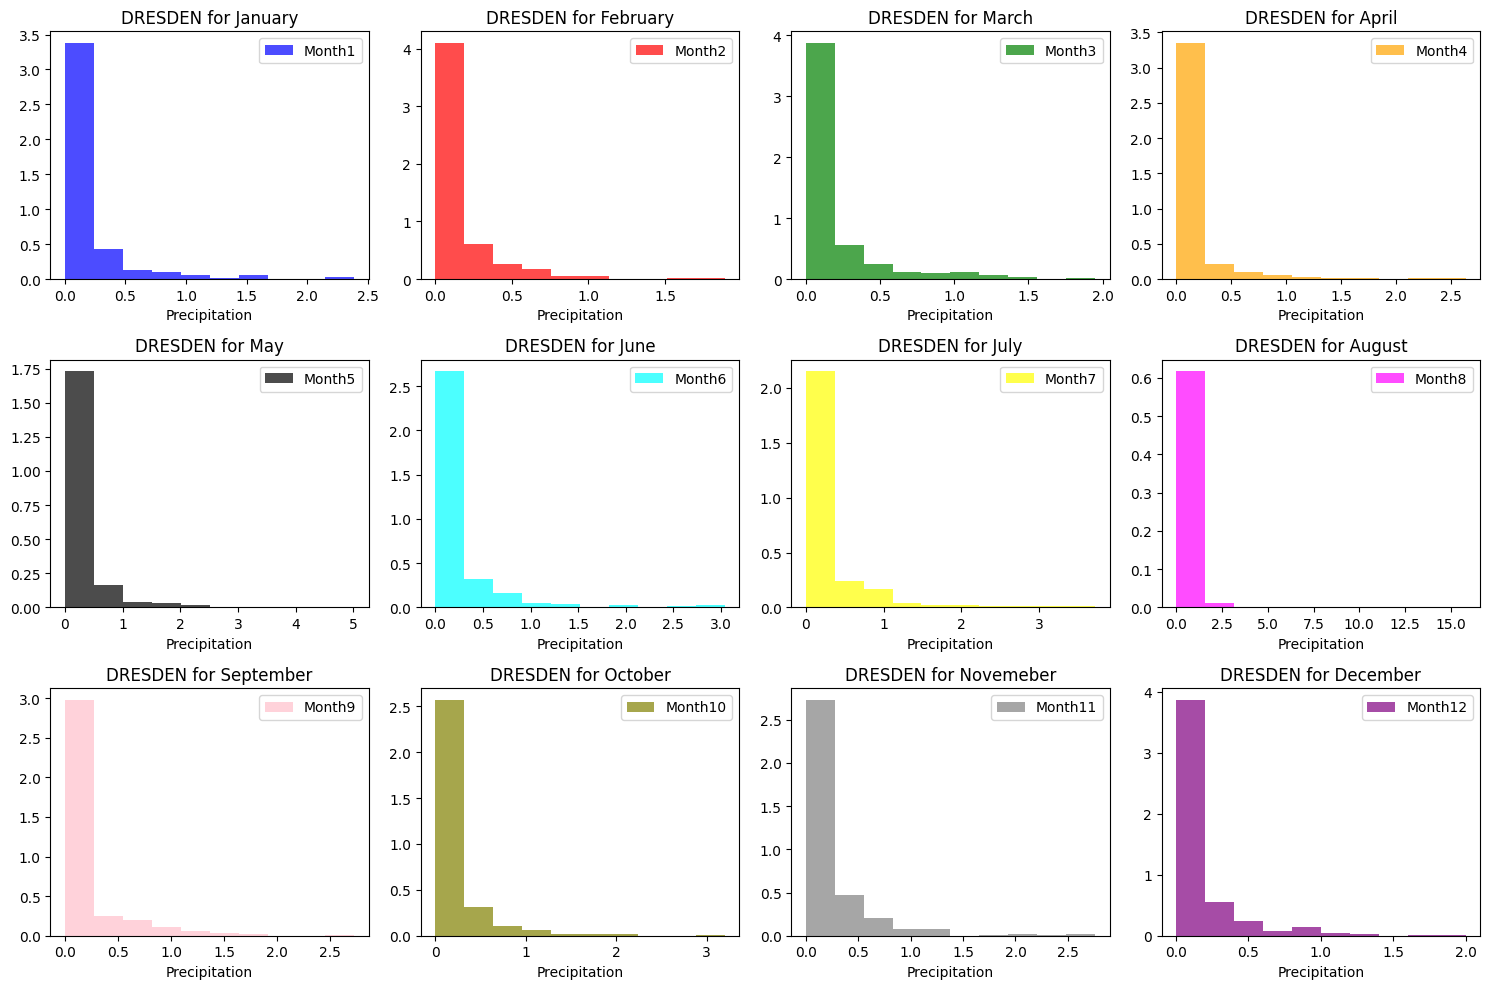

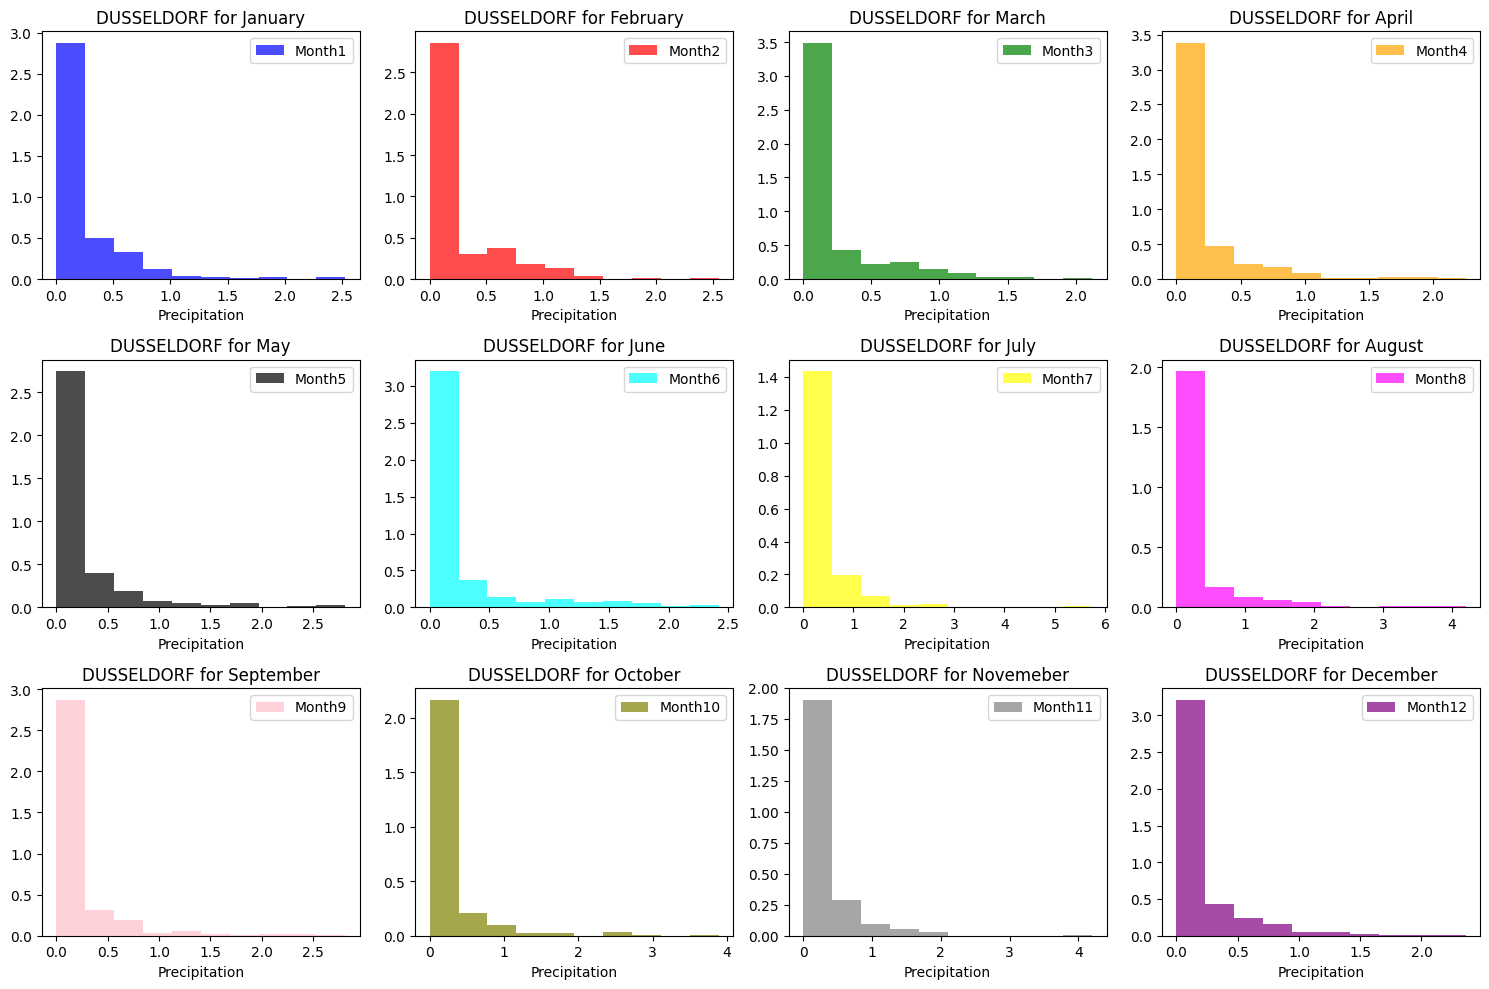

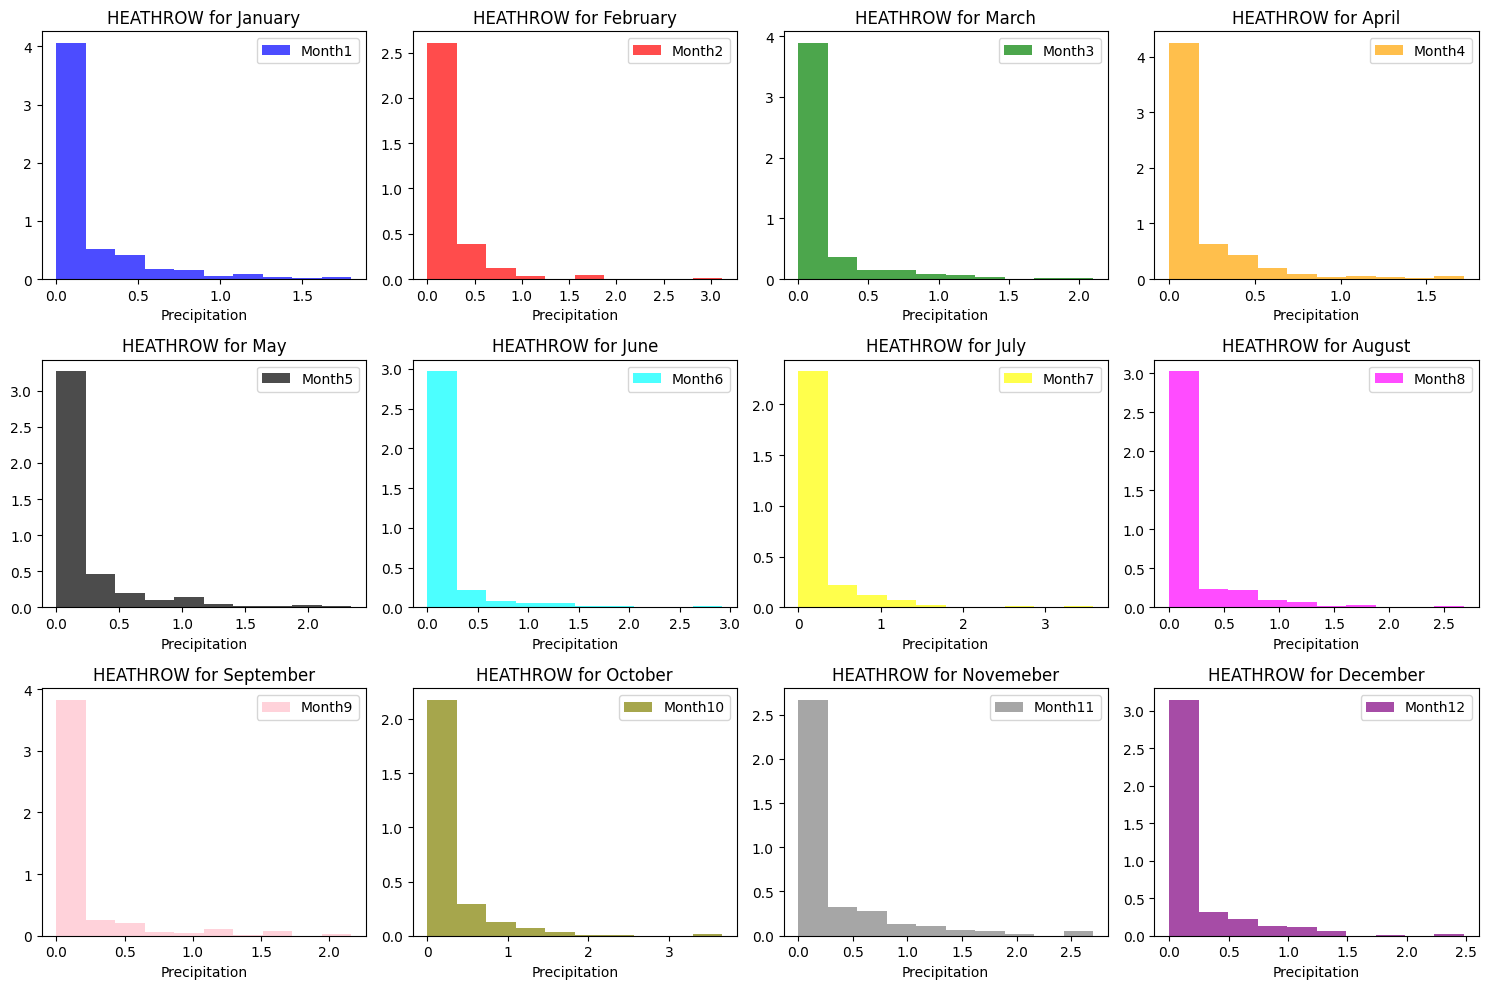

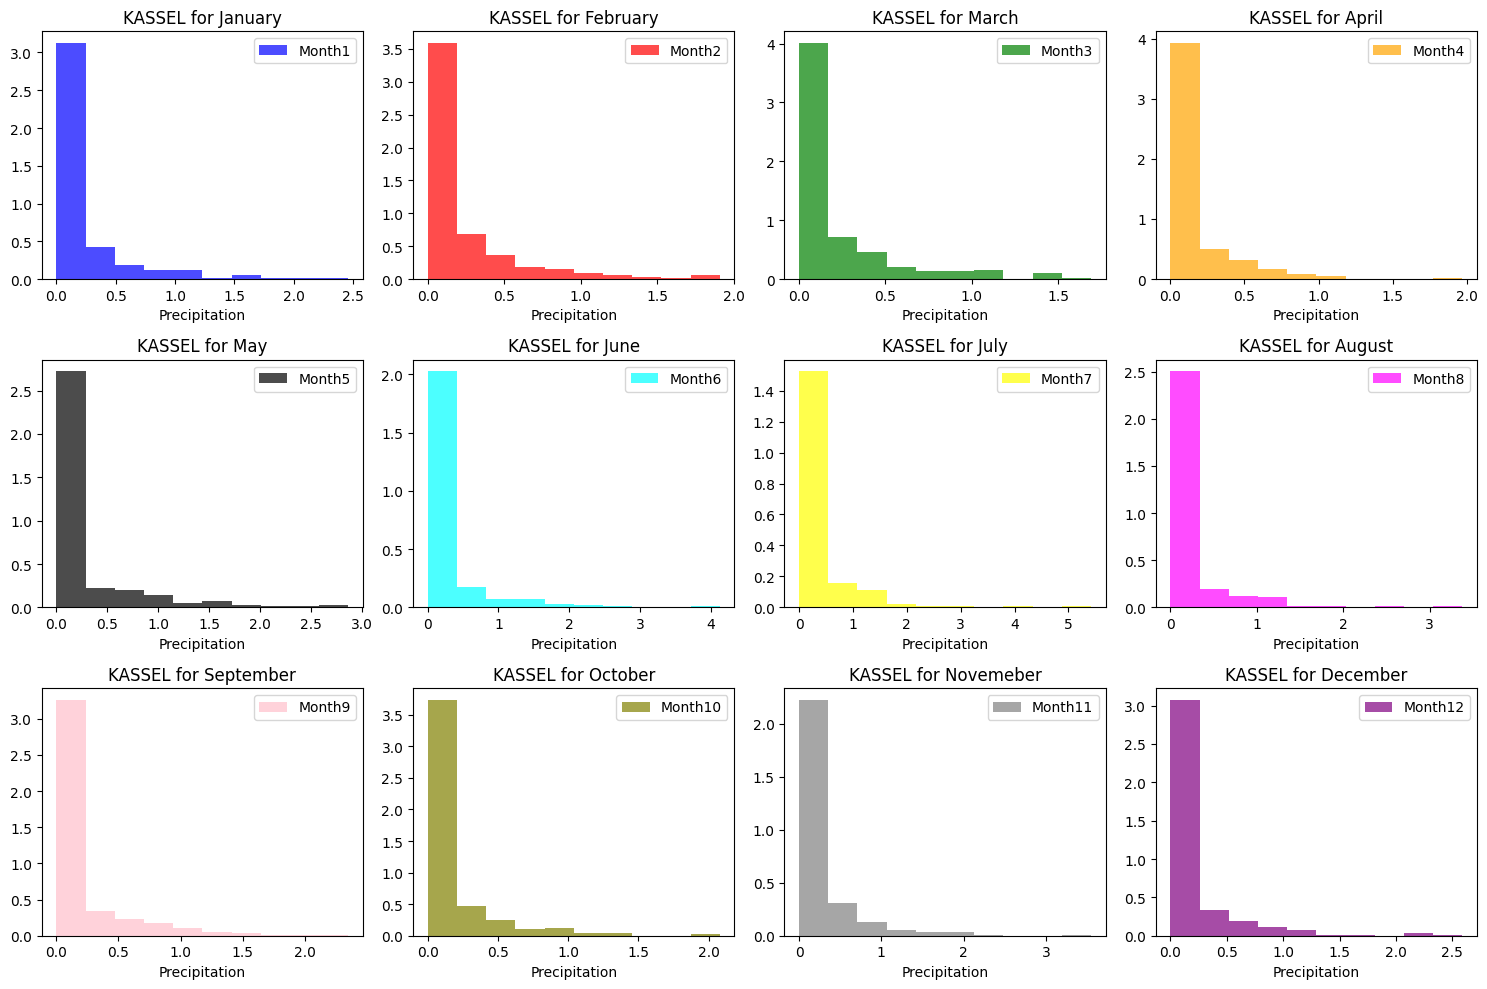

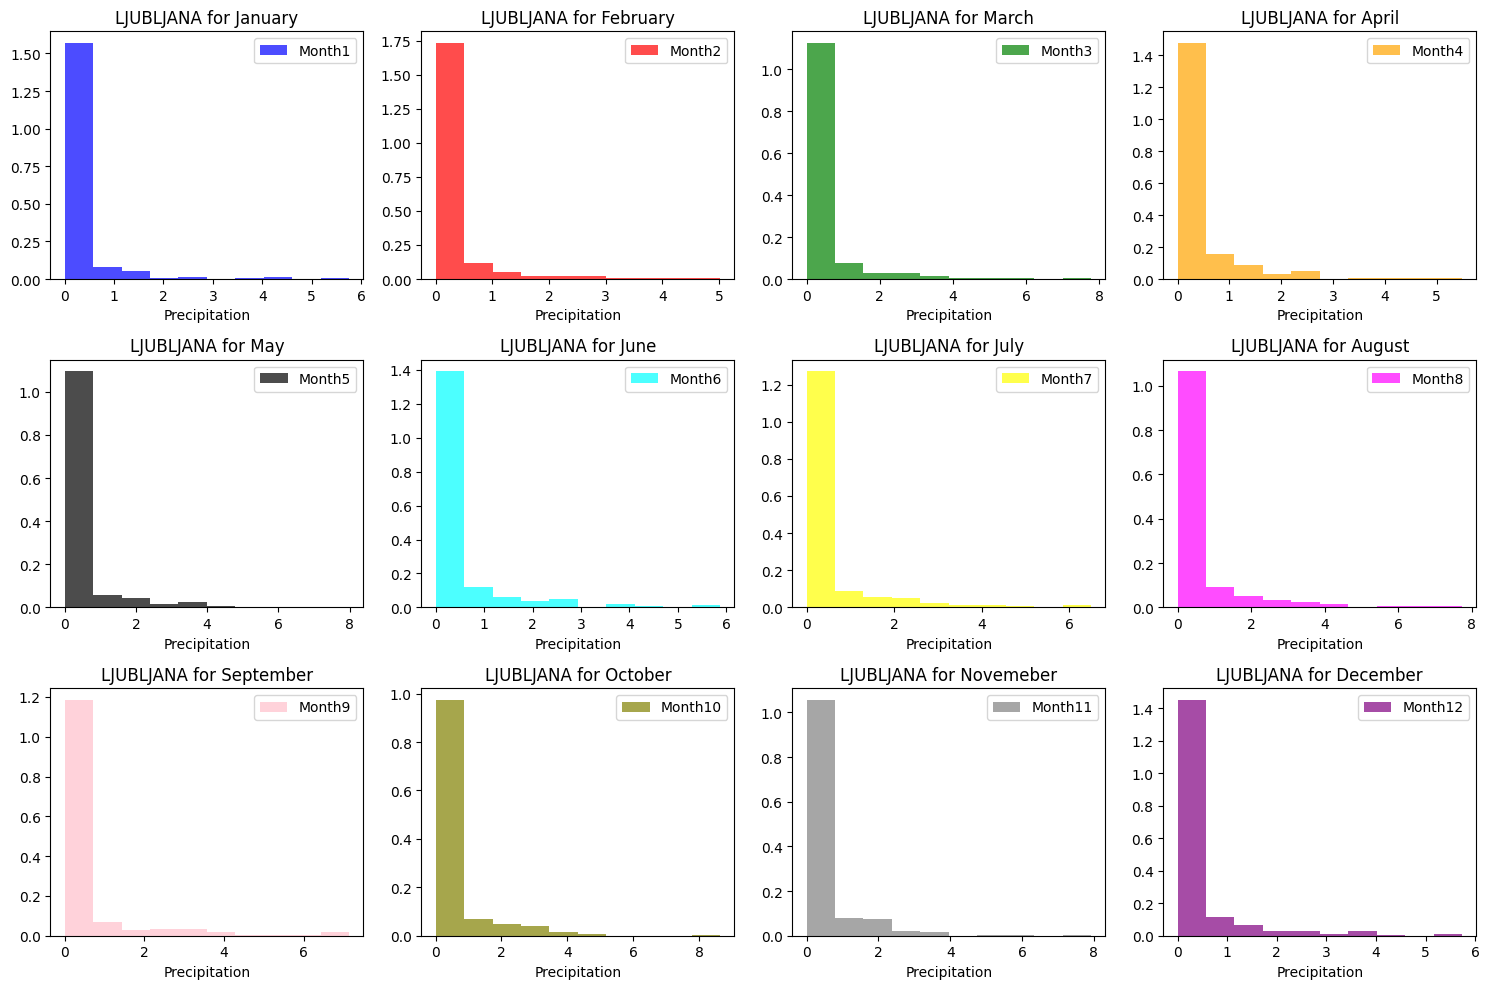

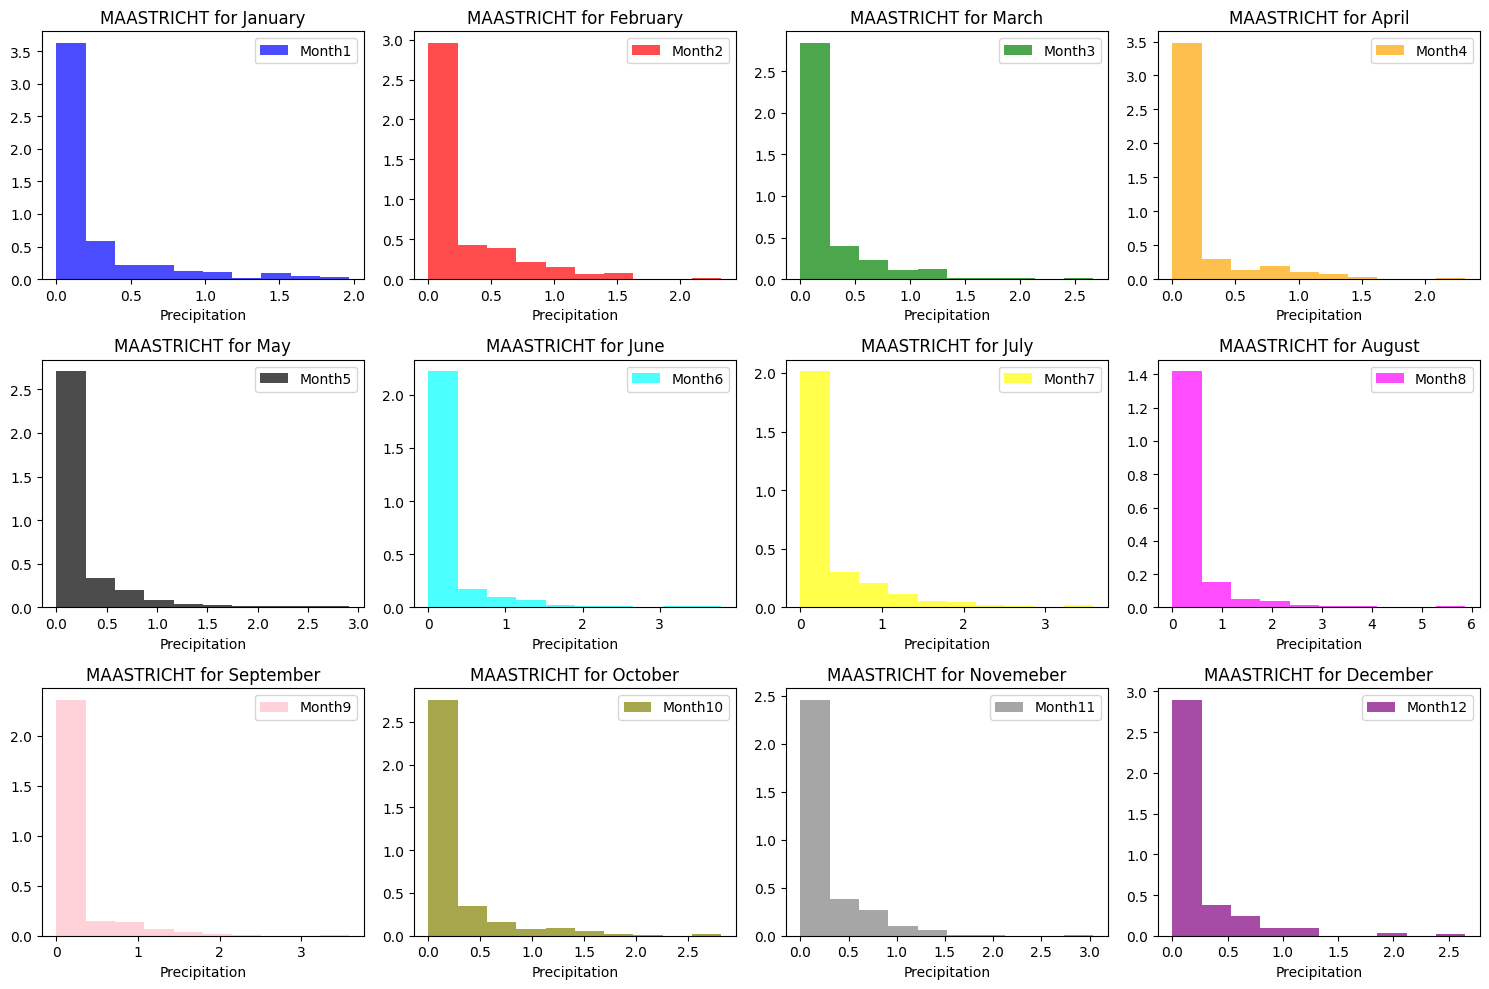

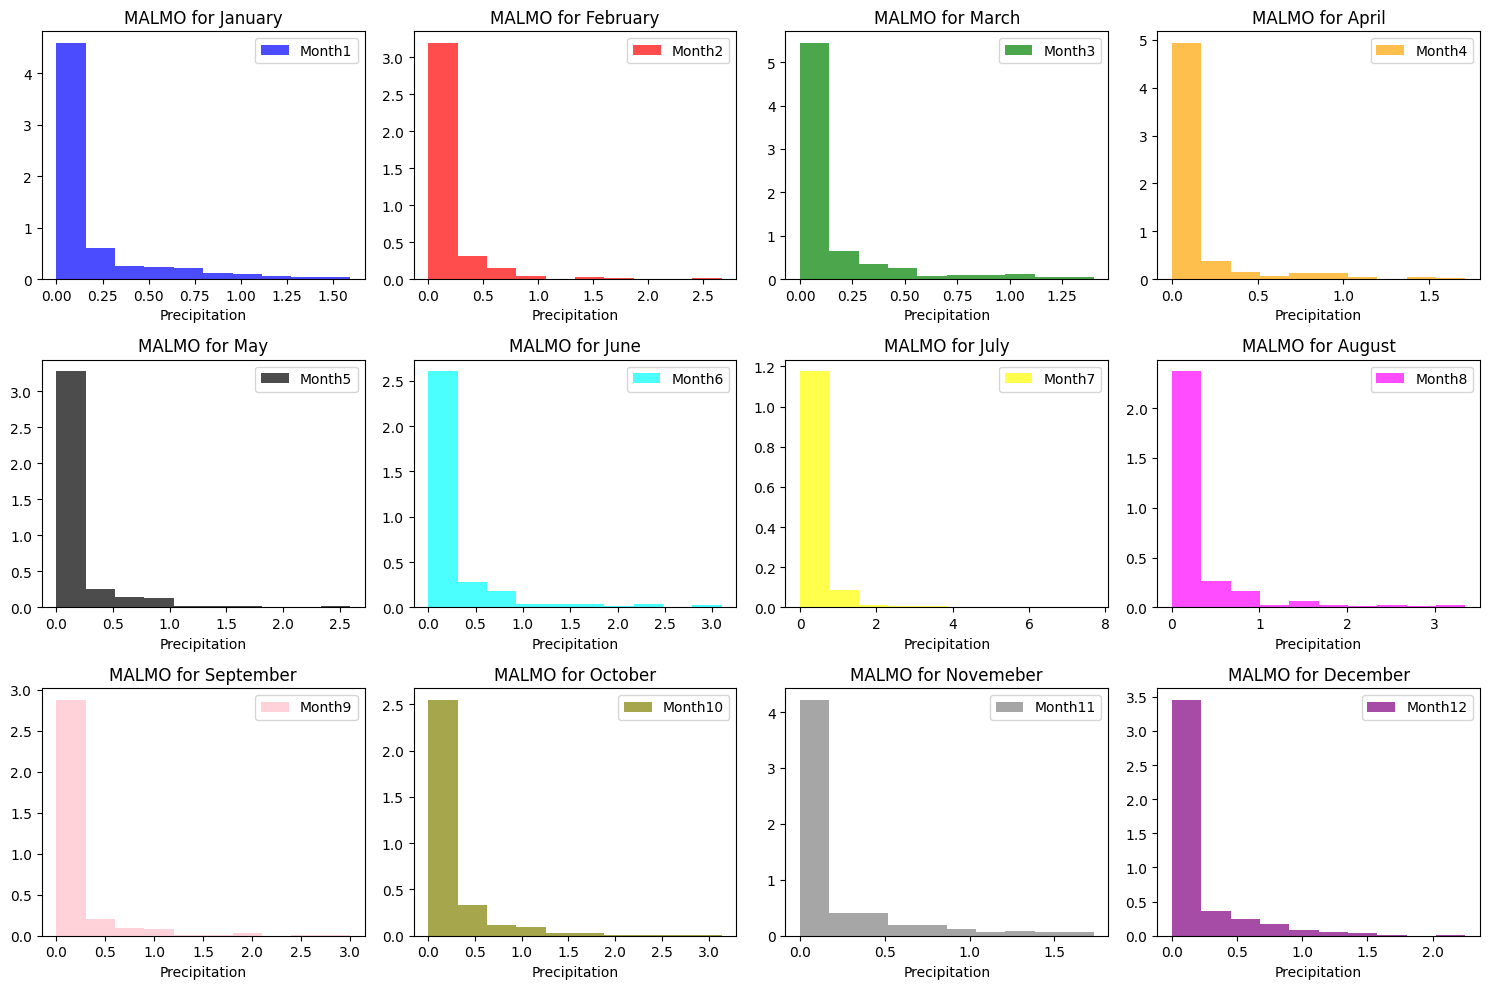

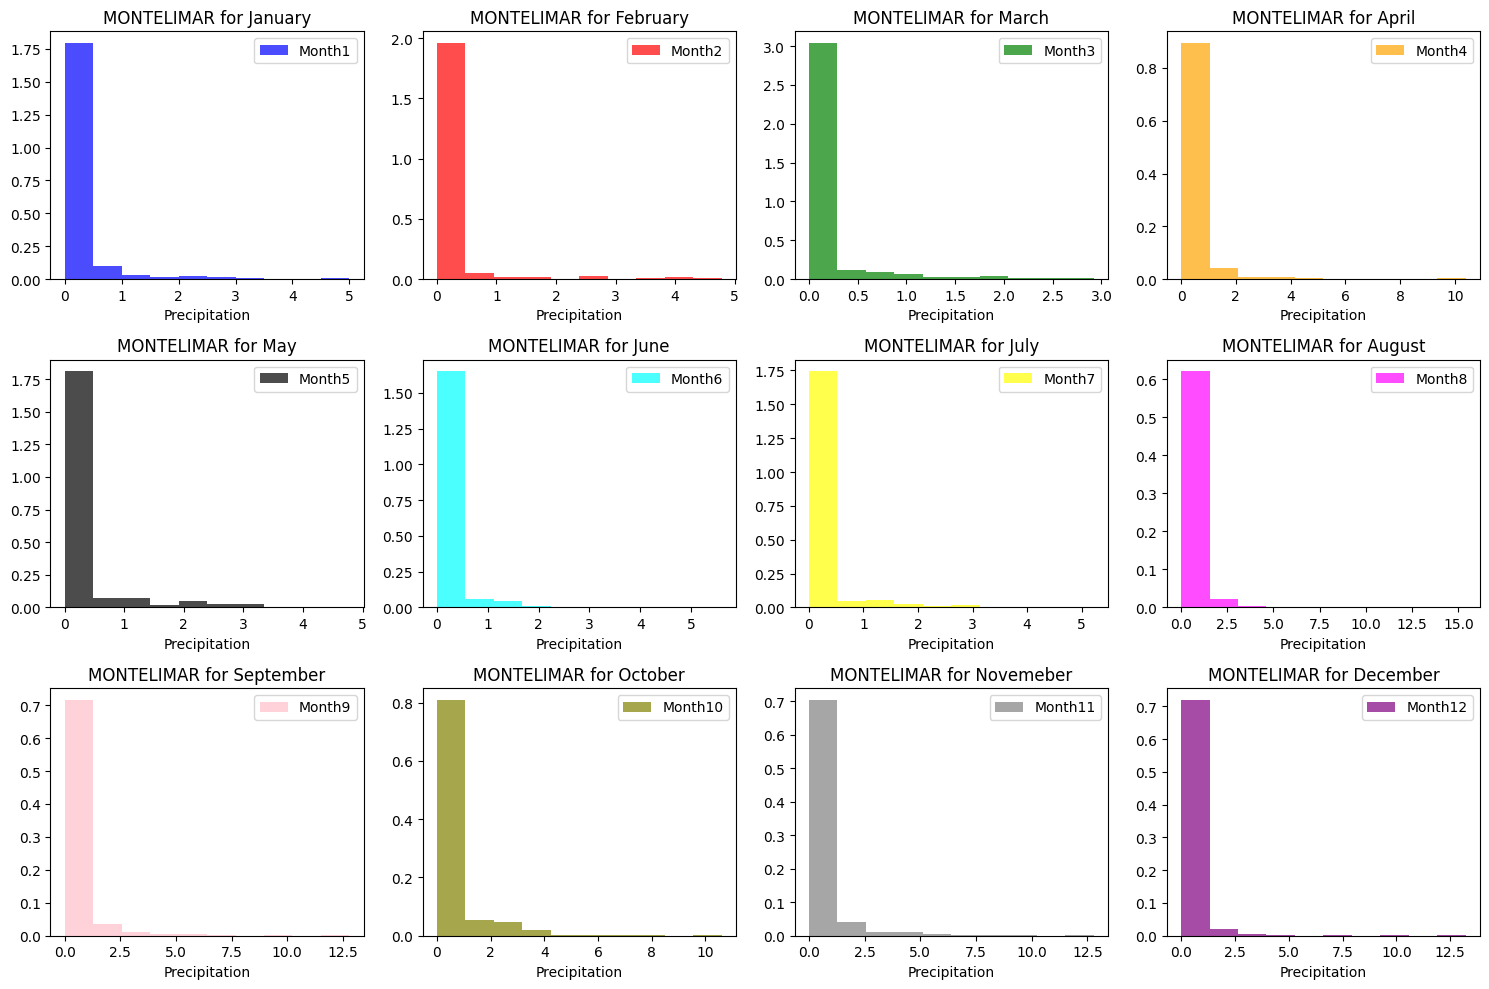

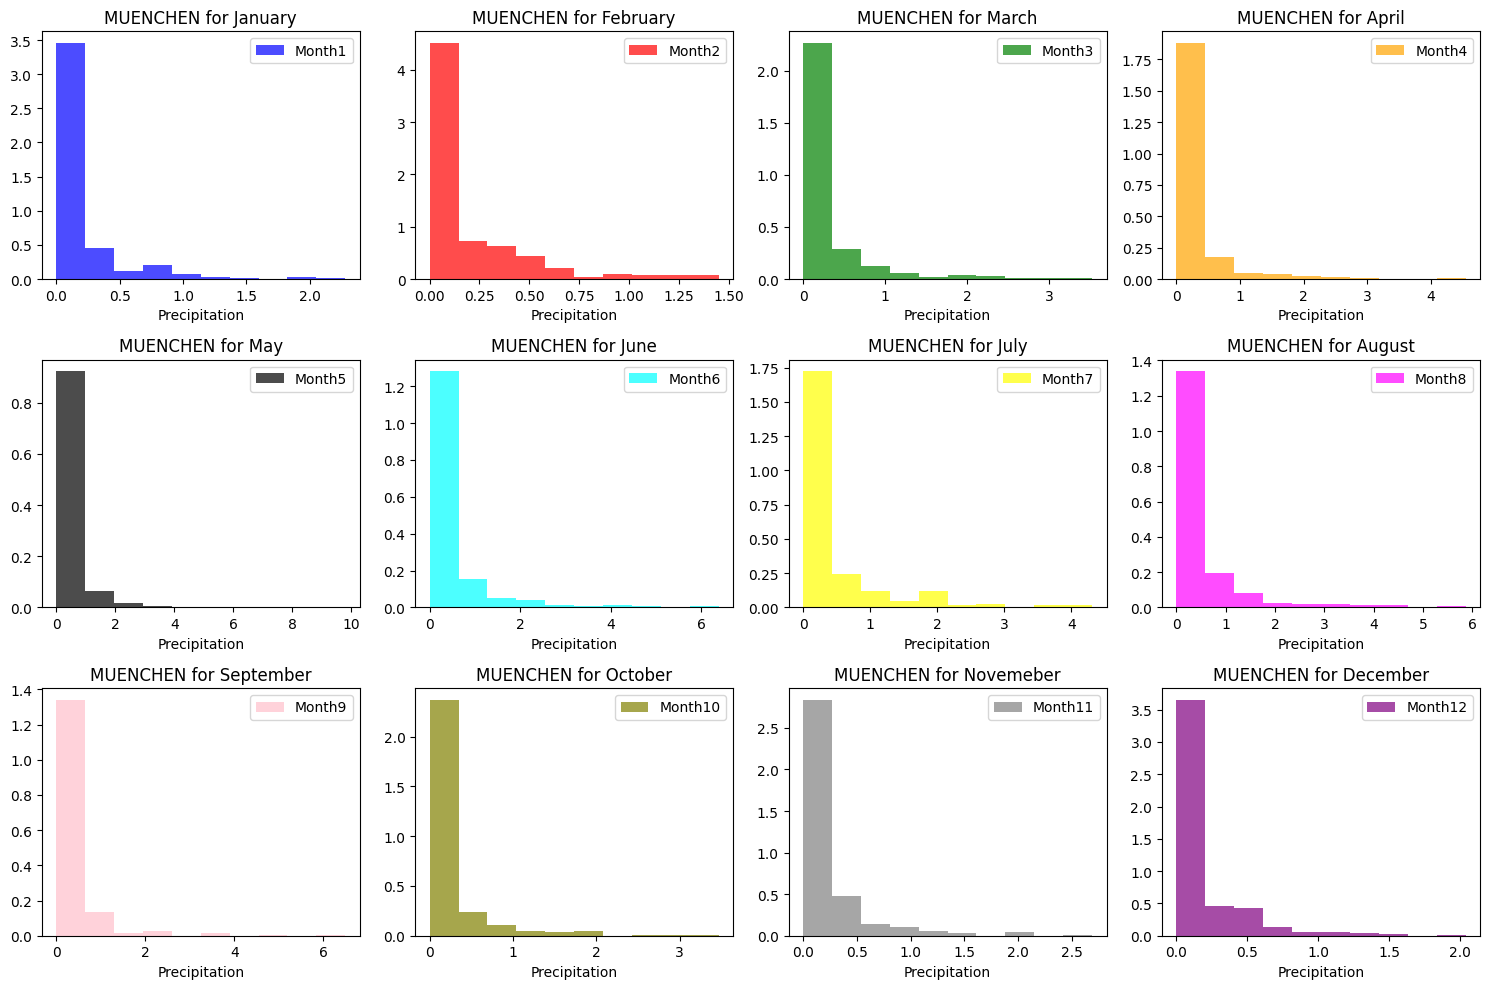

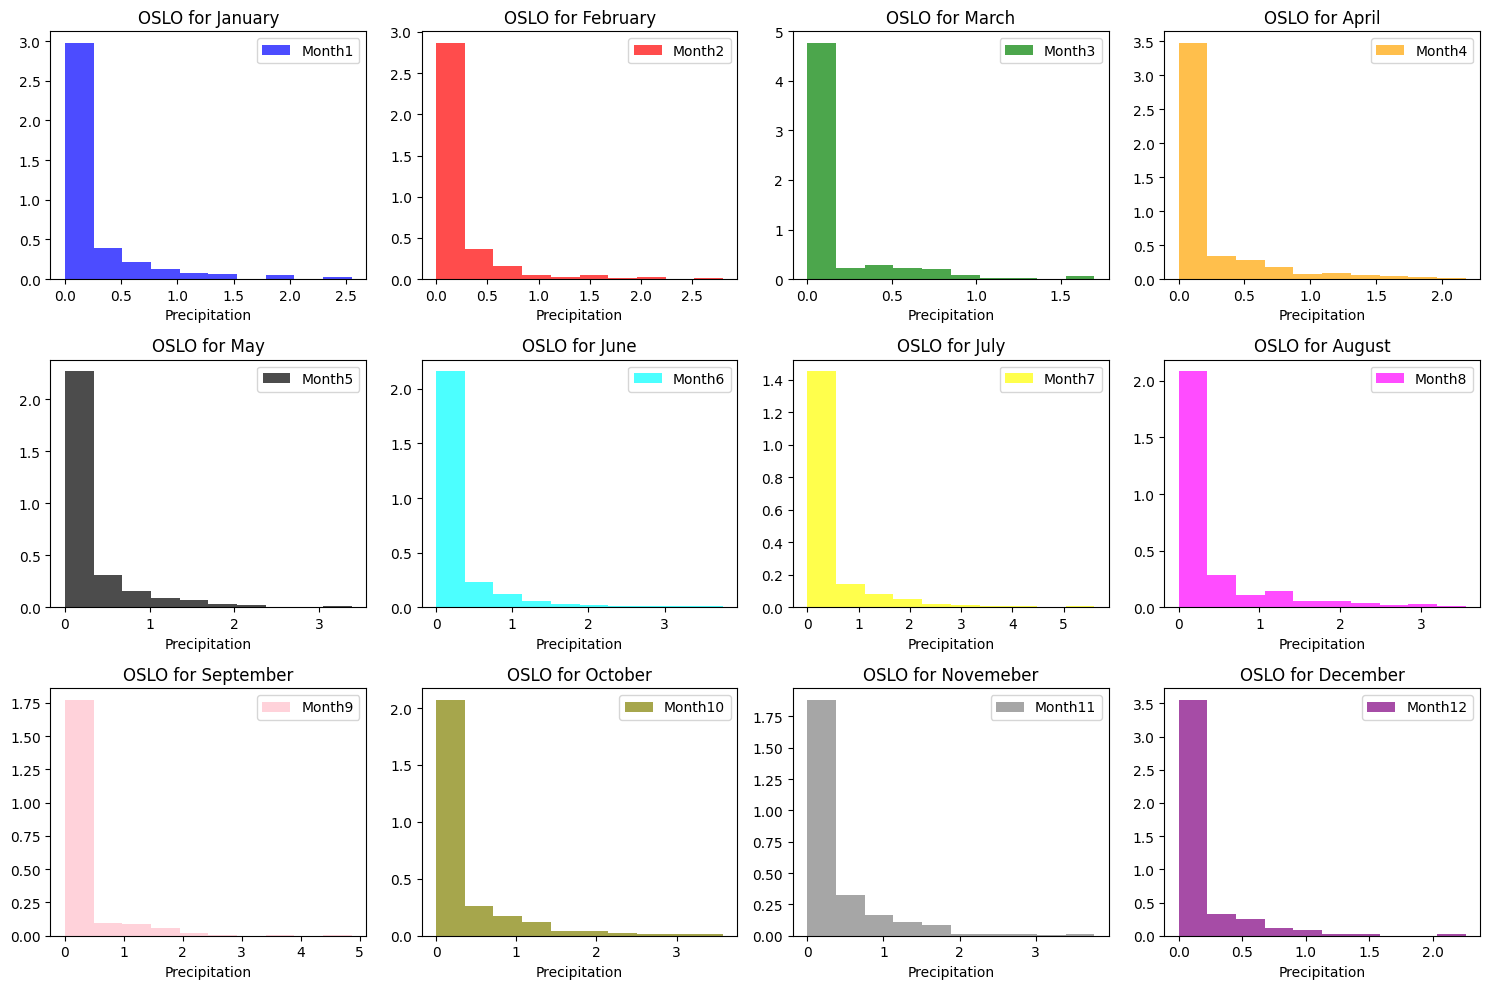

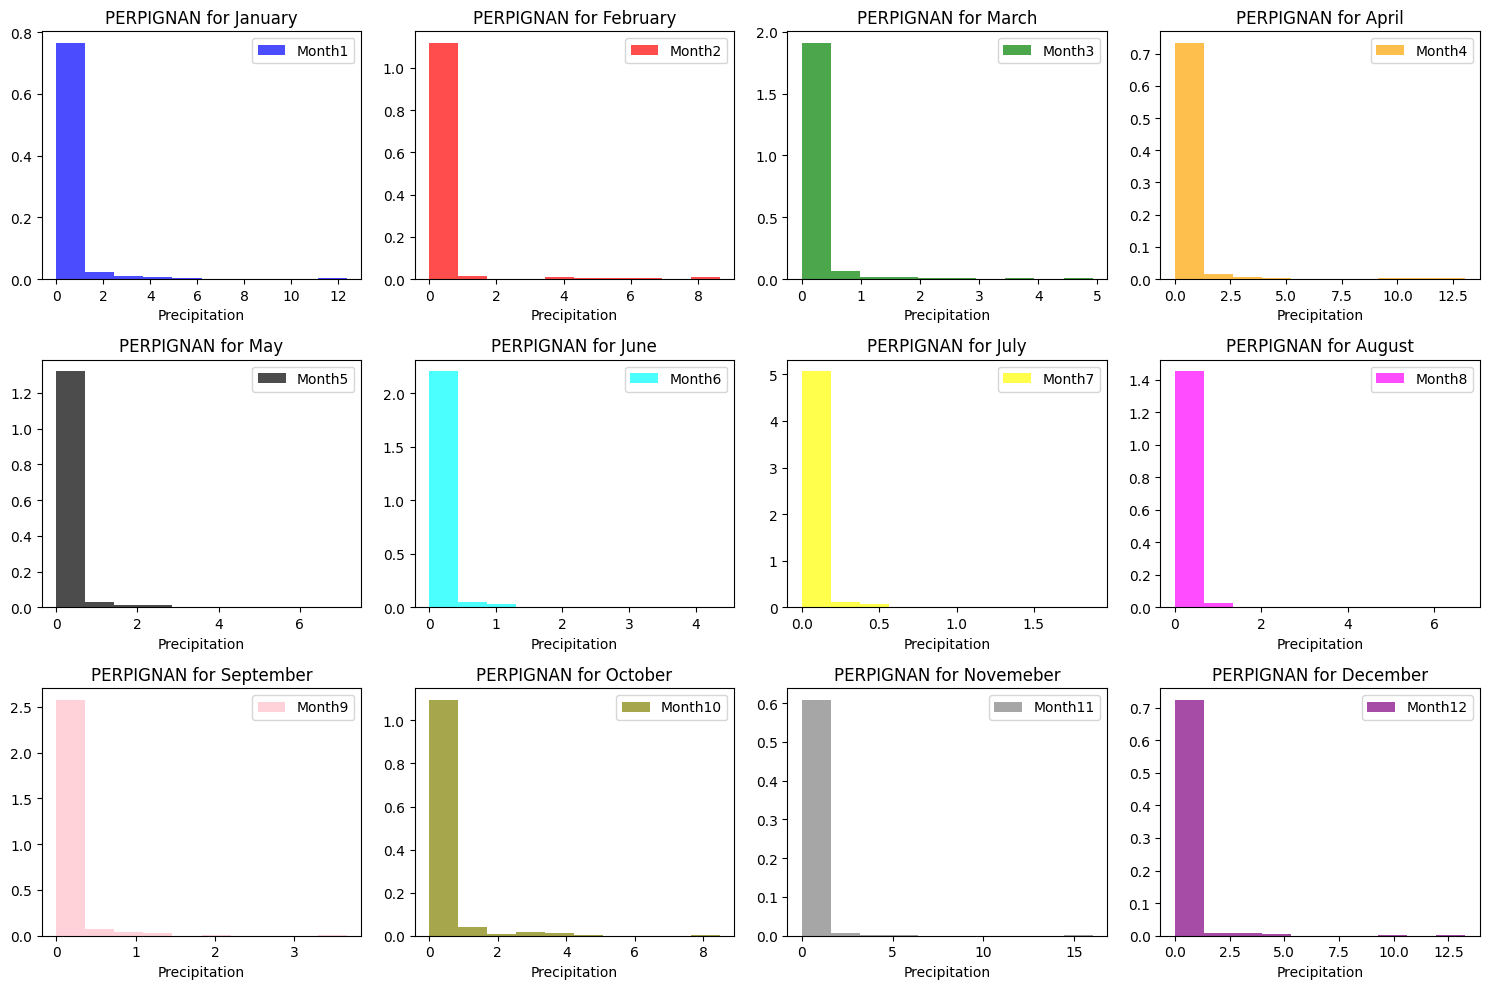

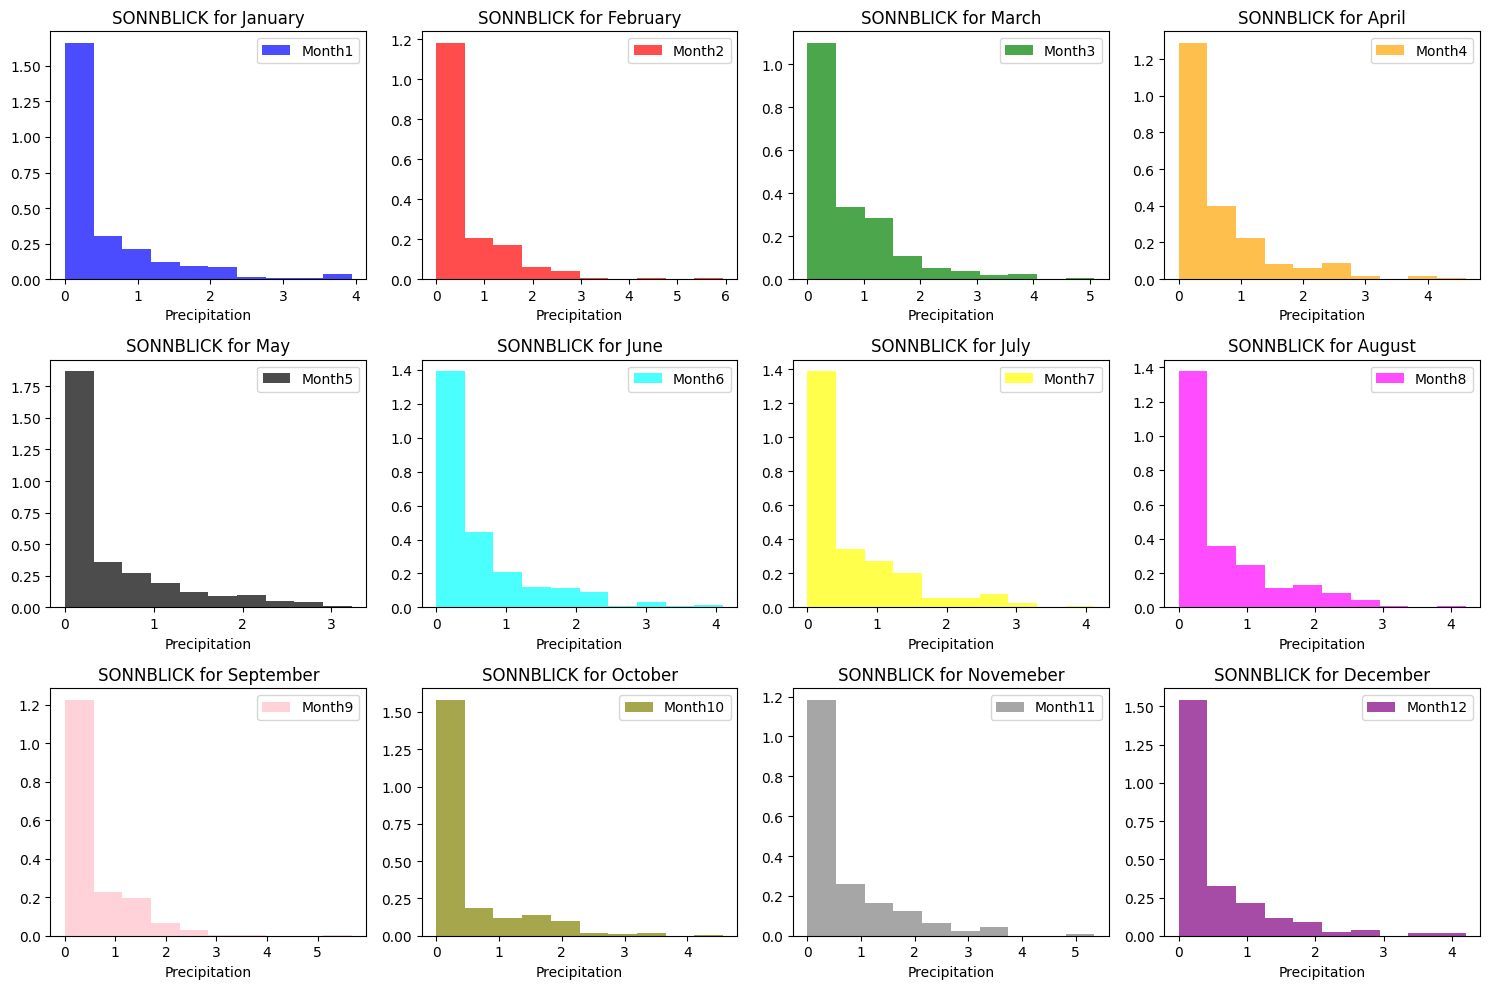

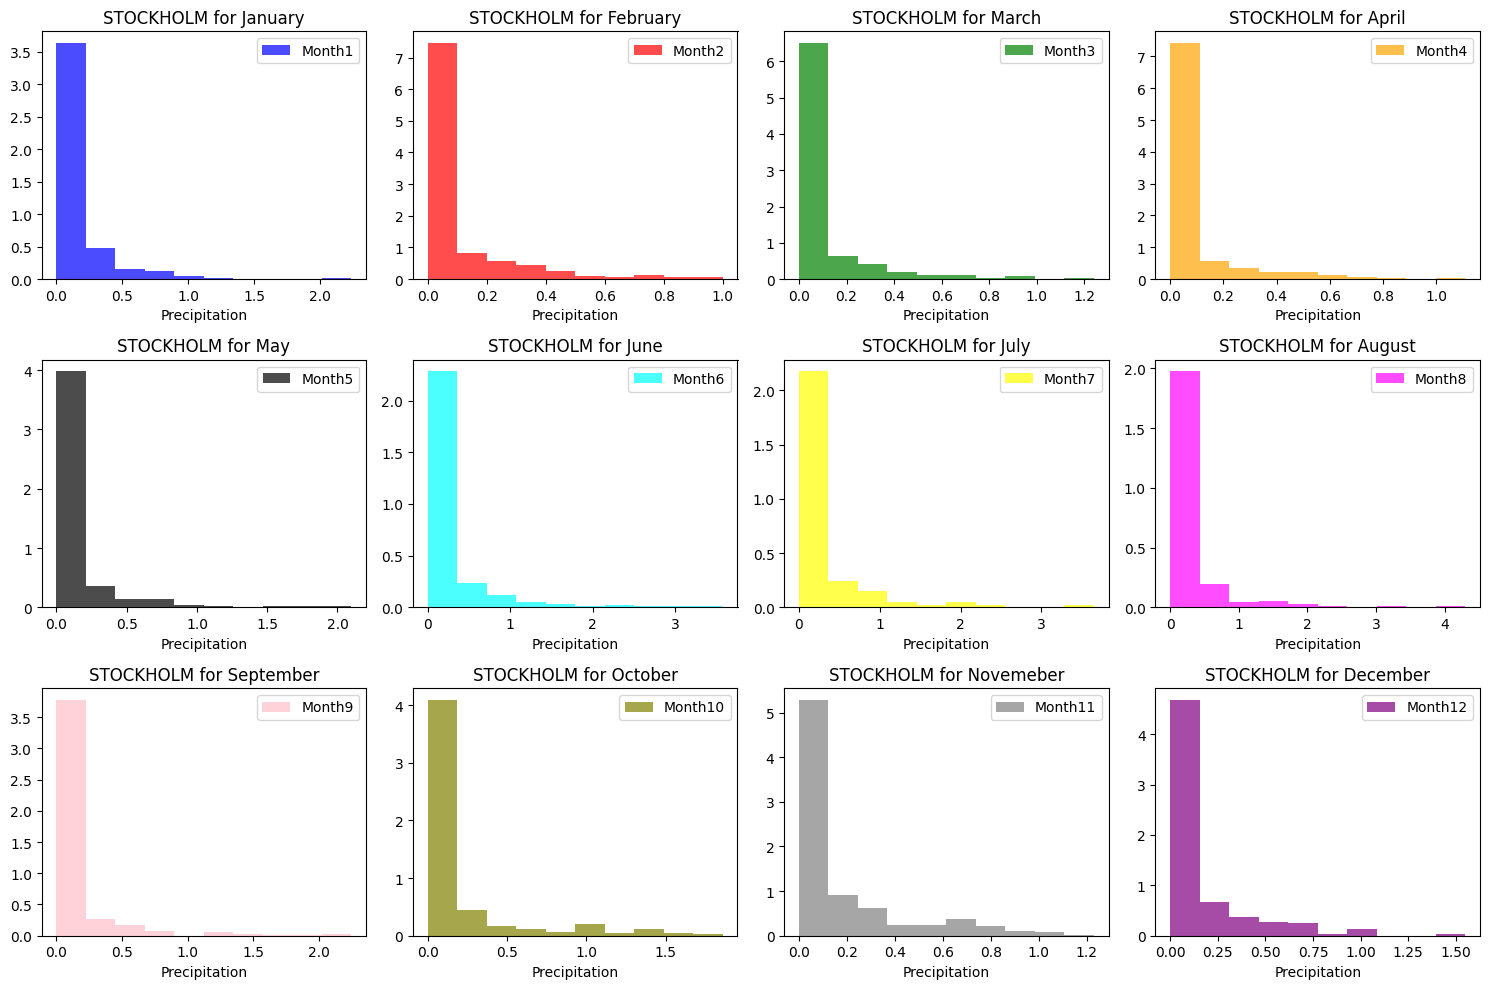

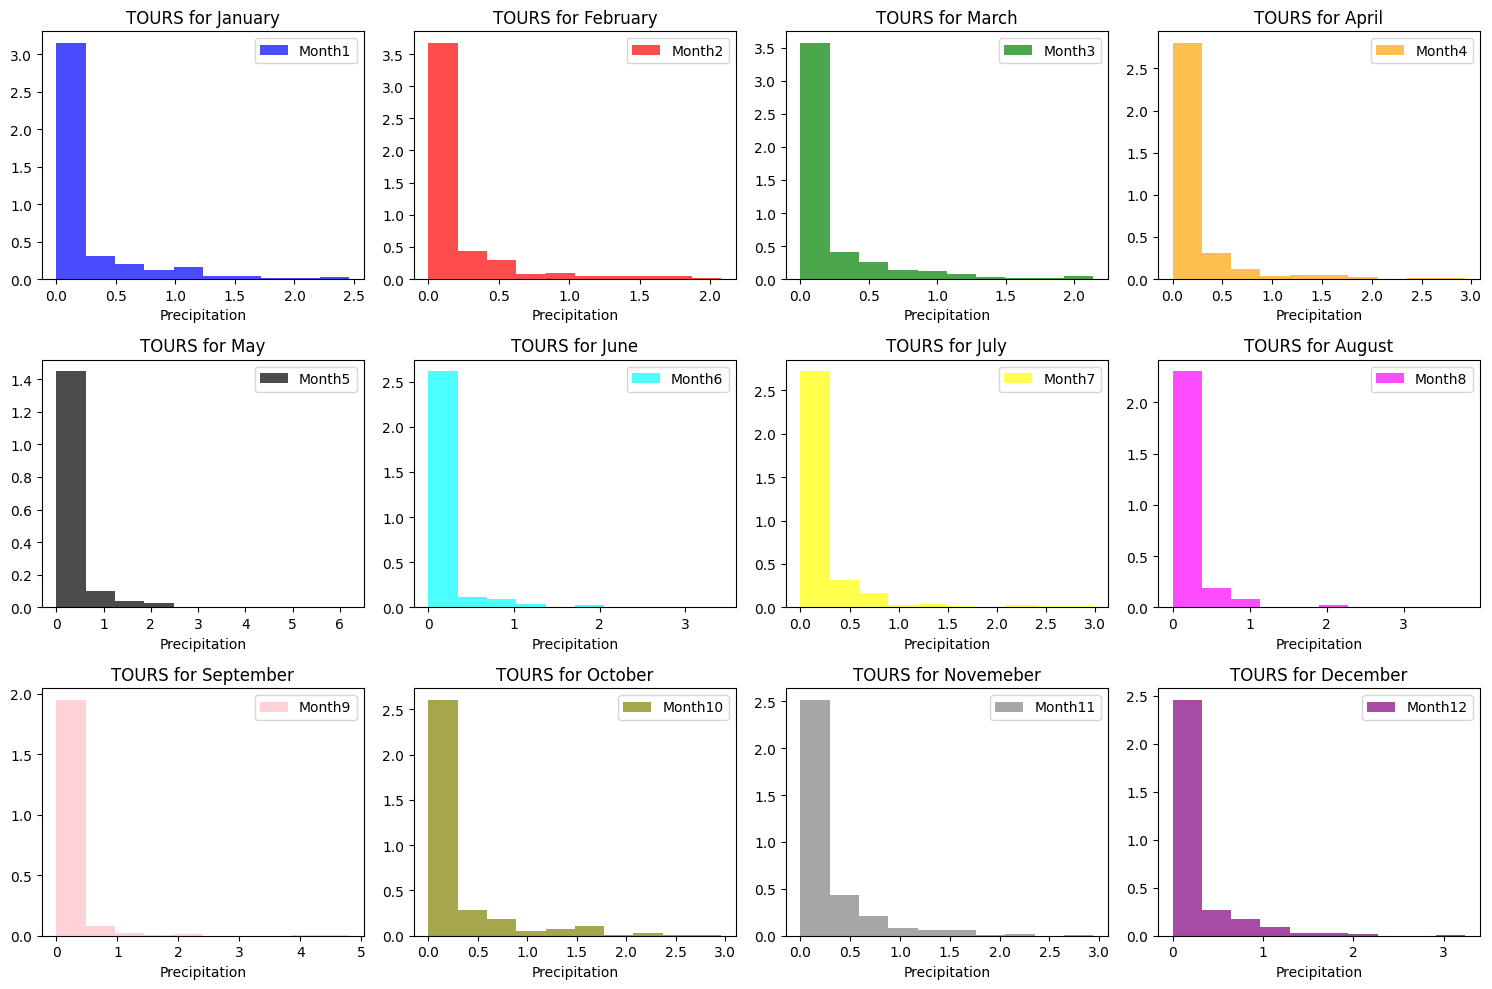

In [110]:
precipitation_labels = [column for column in data.columns if 'precipitation' in column]

for column in precipitation_labels:
    get_monthly_precipitation(column) 

In [111]:
display(results_df)

sunshine                                                      \
       BASEL_sunshine BUDAPEST_sunshine DE_BILT_sunshine DRESDEN_sunshine   
mean         4.661193          5.753229         4.744444         4.815736   
median       3.600000          5.900000         4.100000         3.900000   
std          4.330112          4.475439         3.995637         4.426682   

                                                              \
       DUSSELDORF_sunshine HEATHROW_sunshine KASSEL_sunshine   
mean              4.324111          4.433498        4.136836   
median            3.200000          3.700000        2.900000   
std               4.209463          3.982646        4.159699   

                                                                 ...  \
       LJUBLJANA_sunshine MAASTRICHT_sunshine MUENCHEN_sunshine  ...   
mean             5.412397            4.652354          5.219814  ...   
median           5.200000            3.950000          4.400000  ...   
std              4.507394            4.015278          4.594811  ...   

               cloud_cover                                              \
       DRESDEN_cloud_cover DUSSELDORF_cloud_cover HEATHROW_cloud_cover   
mean              5.405036               5.141762             5.272031   
median            6.000000               6.000000             6.000000   
std               2.194769               2.115639             2.011846   

                                                                          \
       LJUBLJANA_cloud_cover MAASTRICHT_cloud_cover MUENCHEN_cloud_cover   
mean                4.930213               5.337712             5.226054   
median              5.000000               6.000000             6.000000   
std                 2.367843               2.401823             2.318547   

                                                                \
       OSLO_cloud_cover ROMA_cloud_cover SONNBLICK_cloud_cover   
mean           5.608101         3.520799              5.446907   
median         6.000000         3.000000              6.000000   
std            2.170706         2.198344              2.437457   

                              
       STOCKHOLM_cloud_cover  
mean                5.245758  
median              6.000000  
std                 3.362460  

[3 rows x 163 columns]

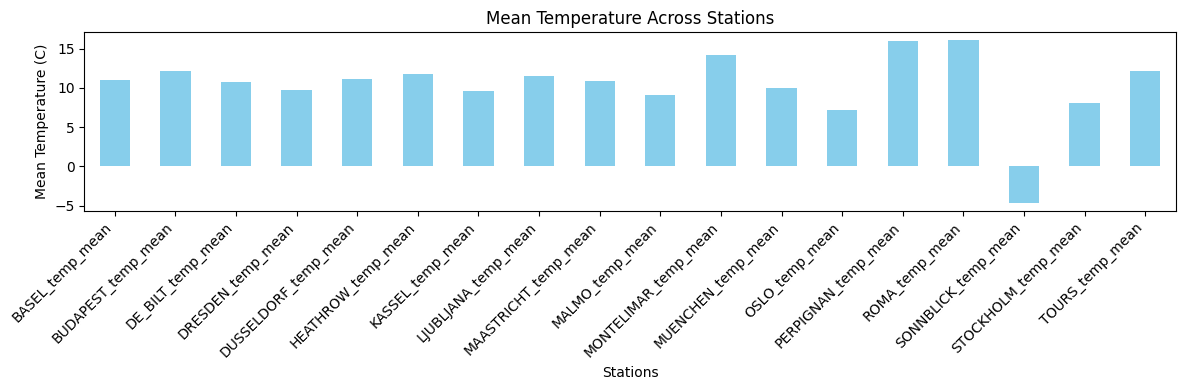

In [112]:
# Plotting the data
plt.figure(figsize=(12, 4))  # Adjust figure size to ensure labels fit well
ax = results_df['temp_mean'].iloc[0].plot(kind='bar', color='skyblue')
ax.set_title('Mean Temperature Across Stations')
ax.set_ylabel('Mean Temperature (C)')
ax.set_xlabel('Stations')

# Rotate labels to prevent overlap
plt.xticks(rotation=45, ha='right')  # Rotate labels slightly and align right for better fit

# Adjust font size
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout() # Enhance readability
plt.show()

In [117]:
data['Season'] = data['MONTH'].apply(assign_season)

# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['DATE'], format='%Y%m%d')

# Filter out columns related to heathrow
heathrow_columns = [col for col in data.columns if 'HEATHROW' in col]

# Include the 'Date' column and 'Season' for context
heathrow_columns += ['Date', 'Season']

# Create a DataFrame for heathrow
heathrow_data = data[heathrow_columns]

# Melt the data to have each weather measurement as a separate column
heathrow_data_melted = heathrow_data.melt(id_vars=['Date', 'Season'], var_name='Measurement', value_name='Value')

In [118]:
display(heathrow_data_melted)

,Date,Season,Measurement,Value
0,2000-01-01,Winter,HEATHROW_cloud_cover,7.0
1,2000-01-02,Winter,HEATHROW_cloud_cover,7.0
2,2000-01-03,Winter,HEATHROW_cloud_cover,8.0
3,2000-01-04,Winter,HEATHROW_cloud_cover,5.0
4,2000-01-05,Winter,HEATHROW_cloud_cover,5.0
...,...,...,...,...
32881,2009-12-28,Winter,HEATHROW_temp_max,5.0
32882,2009-12-29,Winter,HEATHROW_temp_max,5.2
32883,2009-12-30,Winter,HEATHROW_temp_max,4.4
32884,2009-12-31,Winter,HEATHROW_temp_max,3.6


In [131]:
# Split the 'Measurement' column to get individual weather parameters using a list comprehension
split_columns = heathrow_data_melted['Measurement'].str.split('_', expand=True)

# Initialize the 'City' and 'Parameter' columns
heathrow_data_melted['City'] = split_columns[0]
heathrow_data_melted['Parameter'] = split_columns[1]

# Handle cases where there are additional parts for the parameter
for i in range(2, len(split_columns.columns)):
    heathrow_data_melted['Parameter'] = heathrow_data_melted['Parameter'] + '_' + split_columns[i].fillna('')

In [132]:
# Remove trailing underscores if any
heathrow_data_melted['Parameter'] = heathrow_data_melted['Parameter'].str.rstrip('_')

In [133]:
# Pivot the table to have one column for each weather parameter
heathrow_time_series = heathrow_data_melted.pivot_table(index='Date', columns='Parameter', values='Value')

# Reset the index to include 'Date' as a column again
heathrow_time_series = heathrow_time_series.reset_index()

In [134]:
# Display the time series DataFrame
display(heathrow_time_series.head())

Parameter,Date,cloud_cover,global_radiation,humidity,precipitation,pressure,sunshine,temp_max,temp_mean,temp_min
0,2000-01-01,7.0,0.18,0.94,0.00,1.0245,0.4,10.8,7.0,4.9
1,2000-01-02,7.0,0.20,0.89,0.02,1.0253,0.7,11.5,7.9,5.0
2,2000-01-03,8.0,0.13,0.91,0.60,1.0186,0.0,9.5,9.4,7.2
3,2000-01-04,5.0,0.34,0.89,0.02,1.0148,2.9,11.0,7.0,4.4
4,2000-01-05,5.0,0.25,0.85,0.08,1.0142,1.3,10.8,6.4,1.9


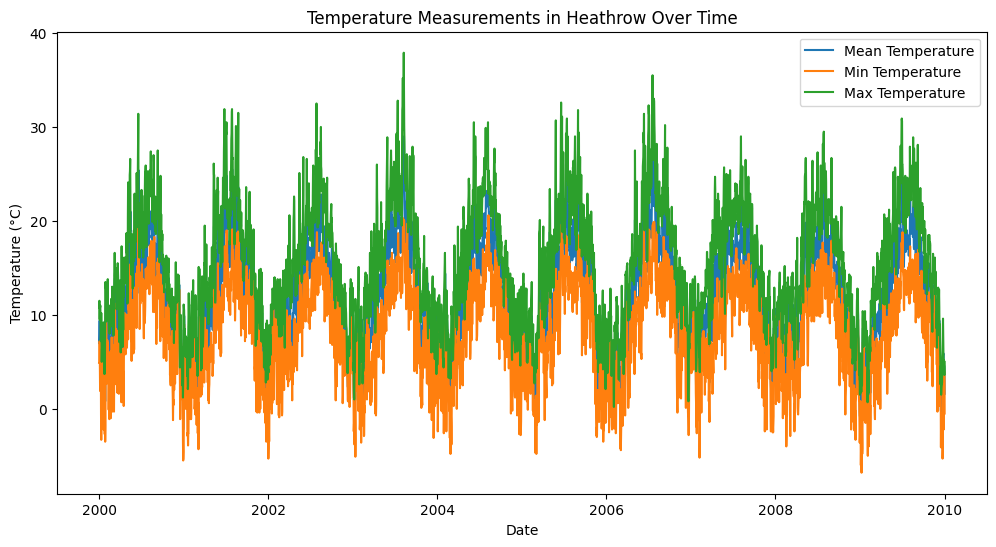

In [135]:
plt.figure(figsize=(12, 6))
plt.plot(heathrow_time_series['Date'], heathrow_time_series['temp_mean'], label='Mean Temperature')
plt.plot(heathrow_time_series['Date'], heathrow_time_series['temp_min'], label='Min Temperature')
plt.plot(heathrow_time_series['Date'], heathrow_time_series['temp_max'], label='Max Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Measurements in Heathrow Over Time')
plt.legend()
plt.show()